### Grading
The final score that you will receive for your programming assignment is generated in relation to the total points set in your programming assignment item—not the total point value in the nbgrader notebook.<br>
When calculating the final score shown to learners, the programming assignment takes the percentage of earned points vs. the total points provided by nbgrader and returns a score matching the equivalent percentage of the point value for the programming assignment.<br>
**DO NOT CHANGE VARIABLE OR METHOD SIGNATURES** The autograder will not work properly if your change the variable or method signatures. 

### WARNING
Please refrain from using **print statements/anything that dumps large outputs(>500 lines) to STDOUT** to avoid running to into **memory issues**. 
Doing so requires your entire lab to be reset which may also result in loss of progress and you will be required to reach out to Coursera for assistance with this.
This process usually takes time causing delays to your submission.

### Validate Button
Please note that this assignment uses nbgrader to facilitate grading. You will see a **validate button** at the top of your Jupyter notebook. If you hit this button, it will run tests cases for the lab that aren't hidden. It is good to use the validate button before submitting the lab. Do know that the labs in the course contain hidden test cases. The validate button will not let you know whether these test cases pass. After submitting your lab, you can see more information about these hidden test cases in the Grader Output. <br>
***Cells with longer execution times will cause the validate button to time out and freeze. Please know that if you run into Validate time-outs, it will not affect the final submission grading.*** <br>

# Homework 5: Ensemble methods (adaBoost, random forests) 

In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone 
from sklearn import tree
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt 
%matplotlib inline 

Run the helper code below to create a training and validation set of threes and eights from the MNIST dataset. There is also a helper function to display digits. 

In [2]:
class ThreesandEights:
    """
    Class to store MNIST 3s and 8s data
    """

    def __init__(self, location):

        import pickle, gzip

        # Load the dataset
        f = gzip.open(location, 'rb')

        # Split the data set 
        x_train, y_train, x_test, y_test = pickle.load(f)
                
        # Extract only 3's and 8's for training set 
        self.x_train = x_train[np.logical_or(y_train== 3, y_train == 8), :]
        self.y_train = y_train[np.logical_or(y_train== 3, y_train == 8)]
        self.y_train = np.array([1 if y == 8 else -1 for y in self.y_train])
        
        # Shuffle the training data 
        shuff = np.arange(self.x_train.shape[0])
        np.random.shuffle(shuff)
        self.x_train = self.x_train[shuff,:]
        self.y_train = self.y_train[shuff]

        # Extract only 3's and 8's for validation set 
        self.x_test = x_test[np.logical_or(y_test== 3, y_test == 8), :]
        self.y_test = y_test[np.logical_or(y_test== 3, y_test == 8)]
        self.y_test = np.array([1 if y == 8 else -1 for y in self.y_test])
        
        f.close()

def view_digit(ex, label=None, feature=None):
    """
    function to plot digit examples 
    """
    if label: print("true label: {:d}".format(label))
    img = ex.reshape(21,21)
    col = np.dstack((img, img, img))
    if feature is not None: col[feature[0]//21, feature[0]%21, :] = [1, 0, 0]
    plt.imshow(col)
    plt.xticks([]), plt.yticks([])
    
data = ThreesandEights("data/mnist21x21_3789.pklz")

true label: 1


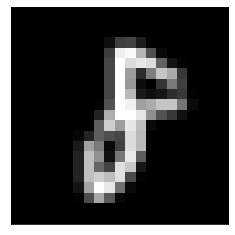

In [3]:
view_digit(data.x_train[0], data.y_train[0])

### Problem 1: Building an Adaboost Classifier to classify MNIST digits 3 and 8.

Recall that the model we attempt to learn in AdaBoost is given by 

$$
H({\bf x}) = \textrm{sign}\left[\displaystyle\sum_{k=1}^K\alpha_k h_k({\bf x}) \right]
$$

where $h_k({\bf x})$ is the $k^\textrm{th}$ weak learner and $\alpha_k$ is it's associated ensemble coefficient. 

**Part A: [Peer Review, 5 pts]** In the `AdaBoost` class below, implement the `fit` method to learn the sequence of weak learners $\left\{h_k({\bf x})\right\}_{k=1}^K$ and corresponding coefficients $\left\{ \alpha_k\right\}_{k=1}^K$. Note that you may use sklearn's implementation of DecisionTreeClassifier as your weak learner which allows you to pass as an optional parameter the weights associated with each training example.  An example of instantiating and training a single learner is given in the comments of the `fit` method.  

Recall that the AdaBoost algorithm is as follows: 

`for k=1 to K:`

$~~~~~~~$ `    a) Fit kth weak learner to training data with weights w`

$~~~~~~~$ `    b) Computed weighted error errk for the kth weak learner (Check Adaboost slides for formula).`

$~~~~~~~$ `    c) compute vote weight alpha[k] = 0.5 ln ((1-errk)/errk))`

$~~~~~~~$ `    d) update training example weights w[i] *= exp[-alpha[k] y[i] h[k](x[i])]`

$~~~~~~~$ `    e) normalize training weights so they sum to 1`
<br><br>
For this week's Peer Review assignment, you wil upload a screenshot of the fit and error_rate functions from the AdaBoost class. Then you will upload a screenshot of using the fit function to fit the Adaboost classifier with 150 base decision stumps. 

In [10]:
class AdaBoost:
    def __init__(self, n_learners=20, base=DecisionTreeClassifier(max_depth=3), random_state=1234):
        """
        Create a new adaboost classifier.
        """
        np.random.seed(42)
        self.n_learners = n_learners
        self.base = base
        self.alpha = np.zeros(self.n_learners)
        self.learners = []

    def fit(self, X_train, y_train):
        n_samples = X_train.shape[0]
        w = np.ones(n_samples, dtype=np.float128)
        w /= np.sum(w)

        y = y_train.copy()
        y[y == 0] = -1  # convert 0/1 labels to -1/1

        for m in range(self.n_learners):
            learner = clone(self.base)
            learner.fit(X_train, y, sample_weight=w)
            y_pred = learner.predict(X_train)

            err = np.sum(w * (y_pred != y)) / np.sum(w)
            err = np.clip(err, 1e-10, 1 - 1e-10)

            alpha = 0.5 * np.log((1 - err) / err)
            w *= np.exp(-alpha * y * y_pred)
            w /= np.sum(w)

            self.learners.append(learner)
            self.alpha[m] = alpha

        return self

    def error_rate(self, y_true, y_pred, weights):
        incorrect = (y_true != y_pred)
        error = np.sum(weights * incorrect) / np.sum(weights)
        return error

    def predict(self, X):
        yhat = np.zeros(X.shape[0], dtype=np.float64)
        for alpha, learner in zip(self.alpha, self.learners):
            yhat += alpha * learner.predict(X)
        yhat = np.sign(yhat)
        yhat[yhat == 0] = 1
        return yhat

    def score(self, X, y):
        yhat = self.predict(X)
        accuracy = np.mean(yhat == y)
        return accuracy

    def staged_score(self, X, y):
        scores = []
        for i in range(len(self.learners)):
            y_sum = np.zeros(X.shape[0])
            for j in range(i + 1):
                y_sum += self.alpha[j] * self.learners[j].predict(X)
            yhat = np.sign(y_sum)
            yhat[yhat == 0] = 1
            acc = np.mean(yhat == y)
            scores.append(acc)
        return np.array(scores)
       


In [11]:
# Sample test for Adaboost error rate function. 
import pytest

y_true = [-1, 1, 1, -1, 1, -1, -1]
y_pred = [-1, 1, 1, 1, 1, -1, 1]
w = np.ones(len(y_true))
w /= np.sum(w)

clf = AdaBoost() 
err_rate = clf.error_rate(y_true, y_pred, w)
assert pytest.approx(err_rate, 0.01) == 0.2857, "Check the error_rate function."


AssertionError: Check the error_rate function.

In [12]:
# Sample test for Adaboost fit function. 

sample_data = np.load('train.npz') 
sample_X = sample_data['X']
sample_y = sample_data['y']
test_model = AdaBoost(n_learners=5).fit(sample_X,sample_y)
t_alpha = [1.94591015, 2.14179328, 2.48490665, 2.42209354, 3.1732565]
assert pytest.approx(test_model.alpha, 0.01) == t_alpha, "Check the fit function"

Use the fit function to fit the Adaboost classifier with 150 base decision tree stumps. [5 pts, Peer Review]

Note: Use data.x_train and data.y_train in fit

In [13]:
# use fit function to fit Adaboost classifier called clf with 150 base decision stumps
# your code here
# Import DecisionTreeClassifier if not already
from sklearn.tree import DecisionTreeClassifier

# Create AdaBoost classifier with 150 weak learners (stumps)
clf = AdaBoost(n_learners=150, base=DecisionTreeClassifier(max_depth=1))

# Fit classifier on your training data
clf.fit(data.x_train, data.y_train)

# The classifier is now trained
print("AdaBoost trained with 150 decision tree stumps.")


# clf = 

AdaBoost trained with 150 decision tree stumps.


In [ ]:
# tests using the fit function to fit AdaBoost classifier with 150 base decision stumps  

**Part B [5 pts]:** After your `fit` method is working properly, implement the `predict` method to make predictions for unseen examples. You can test out the predictions in the cell below.   **Note**: Remember that AdaBoost assumes that your predictions are of the form $y \in \{-1, 1\}$. 

Just print out your predictions on the training set in the cell below.

In [14]:
# print out predictions on the training set 
# your code here
train_predict = clf.predict(data.x_train)

# Print out the predictions
print(train_predict)
# train_predict = 
print(train_predict)

[ 1. -1.  1. ... -1. -1.  1.]
[ 1. -1.  1. ... -1. -1.  1.]


In [15]:
max(train_predict)

1.0

In [16]:
# tests train_predict which uses the predict method  

**Part C [Peer Review]:** Once your `predict` function is written up, you need to test the scores on the function. To do this compute the scores on the prediction in the `score` function. Use the `score` function to then complete `staged_score` to collect the scores for every boosting iterations. Plot the misclassification error for train and test sets (misclassification error = 1- score). <br>
**Note:** your code for this section may cause the Validate button to time out. If you want to run the Validate button prior to submitting, you could comment out the code in this section after completing the Peer Review.

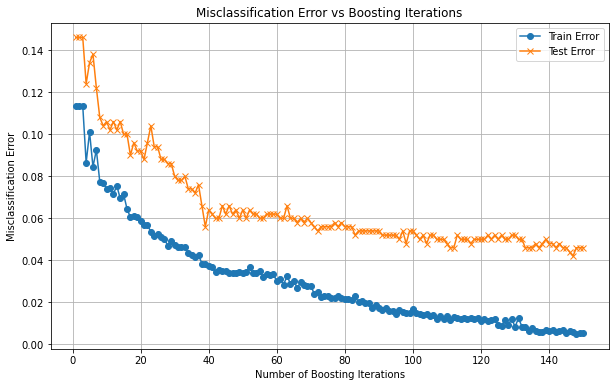

In [17]:
# plot misclassification error for train and test sets 
# your code here
import matplotlib.pyplot as plt

# Compute staged scores
train_scores = clf.staged_score(data.x_train, data.y_train)
test_scores = clf.staged_score(data.x_test, data.y_test)

# Convert to misclassification error
train_error = 1 - train_scores
test_error = 1 - test_scores

# Plot the errors
plt.figure(figsize=(10,6))
plt.plot(range(1, len(train_error)+1), train_error, label='Train Error', marker='o')
plt.plot(range(1, len(test_error)+1), test_error, label='Test Error', marker='x')
plt.xlabel('Number of Boosting Iterations')
plt.ylabel('Misclassification Error')
plt.title('Misclassification Error vs Boosting Iterations')
plt.legend()
plt.grid(True)
plt.show()



### Problem 2 [ 5 pts, Peer Review] : Building an Random Forest Classifier to classify MNIST digits 3 and 8.

Remember that training the random forest algorithms involves the following steps: 

`for k=1 to K:`

$~~~~~~~$ `    a) build kth tree of depth d `

$~~~~~~~$ `    b) Return the kth tree trained on the subset of dataset with the random feature splits`

Predicting the classification result on new data involves returning the majority vote by all the trees in the random forest.


**Part A [5 points, Peer Review]:** Complete the `create_tree` function to build a new tree trained on a subset of data. Within this function a decision tree classifier is built and trained on the subset of data with the subset of features. Answer the Peer Review question for this section. 

In [18]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np

class RandomForest():
    
    def __init__(self, x, y, sample_sz, n_trees=200, n_features='sqrt', max_depth=10, min_samples_leaf=5):
        np.random.seed(42)
        self.x, self.y = x, y
        self.sample_sz = sample_sz
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf

        if n_features == 'sqrt':
            self.n_features = int(np.sqrt(x.shape[1]))
        elif n_features == 'log2':
            self.n_features = int(np.log2(x.shape[1]))
        else:
            self.n_features = n_features

        self.features_set = []
        self.trees = [self.create_tree(i) for i in range(n_trees)]

    def create_tree(self, i):
        # Sample rows and features
        idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        f_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]

        if i == 0:
            self.features_set = np.array(f_idxs, ndmin=2)
        else:
            self.features_set = np.append(self.features_set, np.array(f_idxs, ndmin=2), axis=0)

        # Create and train tree
        clf = DecisionTreeClassifier(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf)
        clf.fit(self.x[idxs][:, f_idxs], self.y[idxs])
        return {'clf': clf, 'f_idxs': f_idxs}

    def predict(self, X):
        n_samples = X.shape[0]
        predictions = np.zeros((n_samples, len(self.trees)))

        for i, tree_dict in enumerate(self.trees):
            clf = tree_dict['clf']
            f_idxs = tree_dict['f_idxs']
            predictions[:, i] = clf.predict(X[:, f_idxs])

        # Majority vote
        yhat = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=1, arr=predictions)
        return yhat

    def score(self, X, y):
        yhat = self.predict(X)
        return np.mean(yhat == y)



In [19]:
# tests create_tree function

In [20]:
import numpy as np

# Create dummy dataset
X_dummy = np.random.rand(100, 10)  # 100 samples, 10 features
y_dummy = np.random.randint(0, 2, 100)  # binary labels

# Initialize RandomForest with small number of trees
rf = RandomForest(X_dummy, y_dummy, sample_sz=50, n_trees=5, max_depth=3, n_features=4, min_samples_leaf=2)

# Check that each tree is a dict with 'clf' and 'f_idxs'
for i, tree in enumerate(rf.trees):
    assert isinstance(tree, dict), f"Tree {i} should be a dictionary"
    assert 'clf' in tree and 'f_idxs' in tree, f"Tree {i} must have 'clf' and 'f_idxs'"
    assert tree['f_idxs'].shape[0] == 4, f"Tree {i} should have 4 features"
    assert isinstance(tree['clf'], DecisionTreeClassifier), f"Tree {i} clf must be DecisionTreeClassifier"

print("All create_tree tests passed!")


All create_tree tests passed!


**Part B [Peer Review]:** In this part you will have to complete three steps: 

1. Complete the `predict` function in RandomForest class so as to make predictions using just the features. 
2. Finally complete the RandomForest class by completing the `score`function to compute the random forest model's accuracy on any dataset. 
3. Build a random forest classifier and train it on the MNIST data to classify 3s and 8s in the cell below. Then see how the classifier performs on the test data by computing the misclassification error. (Remember: error = 1-score)
<br>
Answer the Peer Review questions about this section. 

In [23]:
# TODO: build a random forest classifier and make predictions

# your code here
def predict(self, X):
    """
    Predict labels for input X using the ensemble of trees.
    Majority vote over all trees.
    """
    # Collect predictions from all trees
    all_preds = []
    for tree in self.trees:
        # Only use features selected for this tree
        f_idxs = tree['f_idxs']
        clf = tree['clf']
        preds = clf.predict(X[:, f_idxs])
        all_preds.append(preds)
    
    # Convert to numpy array [n_trees, n_samples]
    all_preds = np.array(all_preds)
    
    # Majority vote along trees axis
    yhat = np.sign(np.sum(all_preds, axis=0))
    
    # Optional: convert zeros to 1 (tie-breaking)
    yhat[yhat == 0] = 1
    
    return yhat

def score(self, X, y):
    """
    Compute accuracy of the RandomForest on dataset (X, y)
    """
    yhat = self.predict(X)
    accuracy = np.mean(yhat == y)
    return accuracy


train_mask = np.isin(data.y_train, [3, 8])
test_mask  = np.isin(data.y_test, [3, 8])

X_train_38 = data.x_train[train_mask]
y_train_38 = data.y_train[train_mask]
X_test_38  = data.x_test[test_mask]
y_test_38  = data.y_test[test_mask]

y_train_38 = np.where(y_train_38 == 3, -1, 1)
y_test_38  = np.where(y_test_38 == 3, -1, 1)

rf = RandomForest(X_train_38, y_train_38, sample_sz=200, n_trees=50, n_features='sqrt', max_depth=10, min_samples_leaf=5)

# Predict on test set
y_pred_test = rf.predict(X_test_38)

# Misclassification error
error = 1 - rf.score(X_test_38, y_test_38)
print("Test Misclassification Error:", error)

clf = DecisionTreeClassifier(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf)
clf.fit(X_subset, y_subset)
return {'clf': clf, 'f_idxs': f_idxs}




print('Misclassification error on test data : %0.3f'%pred_score)

ValueError: Found array with 0 sample(s) (shape=(0, 21)) while a minimum of 1 is required.